In [28]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import layers
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import string
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import random
import time
from pathlib import Path

import re
from IPython import display

In [29]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Preprocess Text

In [30]:
dictionary_path = './dictionary'
vocab = np.load(dictionary_path + '/vocab.npy')
print('there are {} vocabularies in total'.format(len(vocab)))

word2Id_dict = dict(np.load(dictionary_path + '/word2Id.npy'))
id2word_dict = dict(np.load(dictionary_path + '/id2Word.npy'))
print('Word to id mapping, for example: %s -> %s' % ('flower', word2Id_dict['flower']))
print('Id to word mapping, for example: %s -> %s' % ('1', id2word_dict['1']))
print('Tokens: <PAD>: %s; <RARE>: %s' % (word2Id_dict['<PAD>'], word2Id_dict['<RARE>']))

there are 5427 vocabularies in total
Word to id mapping, for example: flower -> 1
Id to word mapping, for example: 1 -> flower
Tokens: <PAD>: 5427; <RARE>: 5428


In [31]:
def sent2IdList(line, MAX_SEQ_LENGTH=20):
    MAX_SEQ_LIMIT = MAX_SEQ_LENGTH
    padding = 0
    
    # data preprocessing, remove all puntuation in the texts
    prep_line = re.sub('[%s]' % re.escape(string.punctuation), ' ', line.rstrip())
    prep_line = prep_line.replace('-', ' ')
    prep_line = prep_line.replace('-', ' ')
    prep_line = prep_line.replace('  ', ' ')
    prep_line = prep_line.replace('.', '')
    tokens = prep_line.split(' ')
    tokens = [
        tokens[i] for i in range(len(tokens))
        if tokens[i] != ' ' and tokens[i] != ''
    ]
    l = len(tokens)
    padding = MAX_SEQ_LIMIT - l
    
    # make sure length of each text is equal to MAX_SEQ_LENGTH, and replace the less common word with <RARE> token
    for i in range(padding):
        tokens.append('<PAD>')
    line = [
        word2Id_dict[tokens[k]]
        if tokens[k] in word2Id_dict else word2Id_dict['<RARE>']
        for k in range(len(tokens))
    ]

    return line

text = "the flower shown has yellow anther red pistil and bright red petals."
print(text)
print(sent2IdList(text))

the flower shown has yellow anther red pistil and bright red petals.
['9', '1', '82', '5', '11', '70', '20', '31', '3', '29', '20', '2', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427']


## Dataset

In [32]:
data_path = './dataset'
df = pd.read_pickle(data_path + '/text2ImgData.pkl')
num_training_sample = len(df)
n_images_train = num_training_sample
print('There are %d image in training data' % (n_images_train))

There are 7370 image in training data


In [33]:
df.head(5)

,Captions,ImagePath
ID,,
6734,"[[9, 2, 17, 9, 1, 6, 14, 13, 18, 3, 41, 8, 11,...",./102flowers/image_06734.jpg
6736,"[[4, 1, 5, 12, 2, 3, 11, 31, 28, 68, 106, 132,...",./102flowers/image_06736.jpg
6737,"[[9, 2, 27, 4, 1, 6, 14, 7, 12, 19, 5427, 5427...",./102flowers/image_06737.jpg
6738,"[[9, 1, 5, 8, 54, 16, 38, 7, 12, 116, 325, 3, ...",./102flowers/image_06738.jpg
6739,"[[4, 12, 1, 5, 29, 11, 19, 7, 26, 70, 5427, 54...",./102flowers/image_06739.jpg


### Create Dataset

In [34]:
# in this competition, you have to generate image in size 64x64x3
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
IMAGE_CHANNEL = 3

def training_data_generator(caption, image_path):
    # load in the image according to image path
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, size=[IMAGE_HEIGHT, IMAGE_WIDTH])
    img.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])
    caption = tf.cast(caption, tf.int32)

    return img, caption

def dataset_generator(filenames, batch_size, data_generator):
    # load the training data into two NumPy arrays
    df = pd.read_pickle(filenames)
    captions = df['Captions'].values
    caption = []
    # each image has 1 to 10 corresponding captions
    # we choose one of them randomly for training
    for i in range(len(captions)):
        caption.append(random.choice(captions[i]))
    caption = np.asarray(caption)
    caption = caption.astype(np.int)
    image_path = df['ImagePath'].values
    
    # assume that each row of `features` corresponds to the same row as `labels`.
    assert caption.shape[0] == image_path.shape[0]
    
    dataset = tf.data.Dataset.from_tensor_slices((caption, image_path))
    dataset = dataset.map(data_generator, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(len(caption)).batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [35]:
BATCH_SIZE = 64
dataset = dataset_generator(data_path + '/text2ImgData.pkl', BATCH_SIZE, training_data_generator)

<ipython-input-34-c5136386d970>:28: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  caption = caption.astype(np.int)


## Conditional GAN

### Text Encoder

In [36]:
class TextEncoder(tf.keras.Model):
    """
    Encode text (a caption) into hidden representation
    input: text, which is a list of ids
    output: embedding, or hidden representation of input text in dimension of RNN_HIDDEN_SIZE
    """
    def __init__(self, hparas):
        super(TextEncoder, self).__init__()
        self.hparas = hparas
        self.batch_size = self.hparas['BATCH_SIZE']
        
        # embedding with tensorflow API
        self.embedding = layers.Embedding(self.hparas['VOCAB_SIZE'], self.hparas['EMBED_DIM'])
        # RNN, here we use GRU cell, another common RNN cell similar to LSTM
        self.gru = layers.GRU(self.hparas['RNN_HIDDEN_SIZE'],
                              return_sequences=True,
                              return_state=True,
                              recurrent_initializer='glorot_uniform')
    
    def call(self, text, hidden):
        text = self.embedding(text)
        # output: (batch_size, sequence_length, rnn_hidden_size)
        output, state = self.gru(text, initial_state = hidden)
        # we only need to output the last hidden state of RNN
        return output[:, -1, :], state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.hparas['BATCH_SIZE'], self.hparas['RNN_HIDDEN_SIZE']))

In [37]:
# from transformers import TFBertModel, BertTokenizer

# # Need to modify the input as raw text?
# class TextEncoder(tf.keras.Model):
#     def __init__(self, hparas):
#         super(TextEncoder, self).__init__()
#         self.hparas = hparas
        
#         # Load pre-trained BERT model and tokenizer
#         self.embedding = tf.keras.layers.Embedding(
#             input_dim = self.hparas['VOCAB_SIZE'],
#             output_dim = 768
#         )
#         self.bert_model = TFBertModel.from_pretrained('bert-base-uncased')
#         self.bert_model.trainable = False
        
#         # Projection layer to match hidden size
#         self.projection = tf.keras.layers.Dense(
#             self.hparas.get('RNN_HIDDEN_SIZE', 768)
#         )
    
#     def call(self, text, hidden=None):
#         # Tokenize and encode text
#         attention_mask = tf.cast(text != word2Id_dict['<PAD>'], tf.int32)
#         embeddings = self.embedding(text)
#         outputs = self.bert_model(
#             input_ids=text,
#             attention_mask=attention_mask
#         )
#         pooled = outputs.pooler_output
#         final_embedding = self.projection(pooled)

#         return final_embedding, final_embedding

    
#     def initialize_hidden_state(self):
#         return tf.zeros((self.hparas['BATCH_SIZE'], self.hparas.get('RNN_HIDDEN_SIZE', 768)))

### Generator

In [38]:
class Generator(tf.keras.Model):
    """
    Generate fake image based on given text(hidden representation) and noise z
    input: text and noise
    output: fake image with size 64*64*3
    """
    def __init__(self, hparas):
        super(Generator, self).__init__()
        self.hparas = hparas
        self.flatten = tf.keras.layers.Flatten()
        self.d1 = tf.keras.layers.Dense(self.hparas['DENSE_DIM'])
        self.d2 = tf.keras.layers.Dense(64*64*3)
        
    def call(self, text, noise_z):
        text = self.flatten(text)
        text = self.d1(text)
        text = tf.nn.leaky_relu(text)
        
        # concatenate input text and random noise
        text_concat = tf.concat([noise_z, text], axis=1)
        text_concat = self.d2(text_concat)
        
        logits = tf.reshape(text_concat, [-1, 64, 64, 3])
        output = tf.nn.tanh(logits)
        
        return logits, output

### Discriminator

In [39]:
class Discriminator(tf.keras.Model):
    """
    Differentiate the real and fake image
    input: image and corresponding text
    output: labels, the real image should be 1, while the fake should be 0
    """
    def __init__(self, hparas):
        super(Discriminator, self).__init__()
        self.hparas = hparas
        self.flatten = tf.keras.layers.Flatten()
        self.d_text = tf.keras.layers.Dense(self.hparas['DENSE_DIM'])
        self.d_img = tf.keras.layers.Dense(self.hparas['DENSE_DIM'])
        self.d = tf.keras.layers.Dense(1)
    
    def call(self, img, text):
        text = self.flatten(text)
        text = self.d_text(text)
        text = tf.nn.leaky_relu(text)
        
        img = self.flatten(img)
        img = self.d_img(img)
        img = tf.nn.leaky_relu(img)
        
        # concatenate image with paired text
        img_text = tf.concat([text, img], axis=1)
        
        logits = self.d(img_text)
        output = tf.nn.sigmoid(logits)
        
        return logits, output

In [40]:
hparas = {
    'MAX_SEQ_LENGTH': 20,                     # maximum sequence length
    'EMBED_DIM': 256,                         # word embedding dimension
    'VOCAB_SIZE': len(word2Id_dict),          # size of dictionary of captions
    'RNN_HIDDEN_SIZE': 128,                   # number of RNN neurons
    'Z_DIM': 512,                             # random noise z dimension
    'DENSE_DIM': 128,                         # number of neurons in dense layer
    'IMAGE_SIZE': [64, 64, 3],                # render image size
    'BATCH_SIZE': 64,
    'LR': 1e-4,
    'LR_DECAY': 0.5,
    'BETA_1': 0.5,
    'N_EPOCH': 10,                            # number of epoch for demo
    'N_SAMPLE': num_training_sample,          # size of training data
    'CHECKPOINTS_DIR': './checkpoints/demo',  # checkpoint path
    'PRINT_FREQ': 1                           # printing frequency of loss
}

In [41]:
text_encoder = TextEncoder(hparas)
generator = Generator(hparas)
discriminator = Discriminator(hparas)

### Test: Pretrain our text encoder

In [42]:
# # # Image embedding model
# base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL))
# pooling_layer = layers.GlobalAveragePooling2D()(base_model.output)
# image_model = tf.keras.Model(inputs=base_model.input, outputs=pooling_layer)

# text_encoder_optimizer = tf.keras.optimizers.Adam(1e-3)

# tf.config.run_functions_eagerly(True)
# @tf.function
# def structured_loss(image_features, text_features):
#     # Image-text compatibility scores
#     image_features = tf.nn.l2_normalize(image_features, axis=1)
#     text_features = tf.nn.l2_normalize(text_features, axis=1)
#     scores = tf.reduce_sum(image_features * text_features, axis=1)
    
#     return tf.reduce_sum(scores)

# for epoch in range(100):
#     hidden = text_encoder.initialize_hidden_state()
#     for image, caption in dataset:
#         image_embedding = image_model(image)
#         with tf.GradientTape() as tape:
#             text_embed, hidden = text_encoder(caption, hidden)
#             loss = structured_loss(image_embedding, text_embed)
#             print(f"epoch {epoch}, loss {loss}")

#         grad = tape.gradient(loss, text_encoder.trainable_variables)
#         text_encoder_optimizer.apply_gradients(zip(grad, text_encoder.trainable_variables))

## Loss Function and Optimization

In [43]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [44]:
def discriminator_loss(real_logits, fake_logits):
    # output value of real image should be 1
    real_loss = cross_entropy(tf.ones_like(real_logits), real_logits)
    # output value of fake image should be 0
    fake_loss = cross_entropy(tf.zeros_like(fake_logits), fake_logits)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    # output value of fake image should be 0
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [45]:
# we use seperated optimizers for training generator and discriminator
generator_optimizer = tf.keras.optimizers.Adam(hparas['LR'])
discriminator_optimizer = tf.keras.optimizers.Adam(hparas['LR'])
text_encoder_optimizer = tf.keras.optimizers.Adam(hparas['LR'])

In [46]:
# one benefit of tf.train.Checkpoint() API is we can save everything seperately
checkpoint_dir = hparas['CHECKPOINTS_DIR']
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 text_encoder=text_encoder,
                                 generator=generator,
                                 discriminator=discriminator, 
                                 text_encoder_optimizer=text_encoder_optimizer)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [65]:
@tf.function
def image_aug(img):
    img = tf.image.random_flip_left_right(img)
    height, width = img.shape[1], img.shape[2]

    # random tranlation
    dx = tf.random.uniform([], -5, 5, dtype=tf.int32)
    dy = tf.random.uniform([], -5, 5, dtype=tf.int32)
    img = tf.image.pad_to_bounding_box(
        img, 
        offset_height=tf.maximum(0, dy), 
        offset_width=tf.maximum(0, dx), 
        target_height=height + tf.abs(dy), 
        target_width=width + tf.abs(dx)
    )
    img = tf.image.crop_to_bounding_box(
        img, 
        offset_height=tf.maximum(0, -dy), 
        offset_width=tf.maximum(0, -dx), 
        target_height=height, 
        target_width=width
    )

    # random zoom
    zoom_factor = tf.random.uniform([], 0.8, 1.2)
    new_height, new_width = tf.cast(height * zoom_factor, tf.int32), tf.cast(width * zoom_factor, tf.int32)
    img = tf.image.resize(img, [new_height, new_width])
    img = tf.image.resize_with_crop_or_pad(img, height, width)
    return img

(64, 64, 64, 3)
(64, 64, 64, 3)


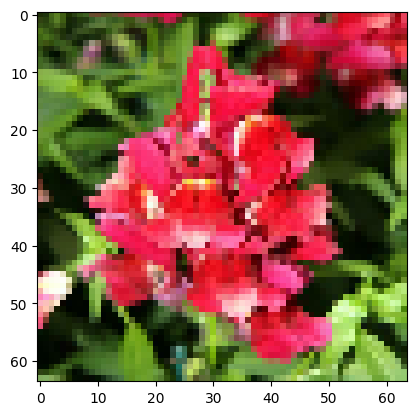

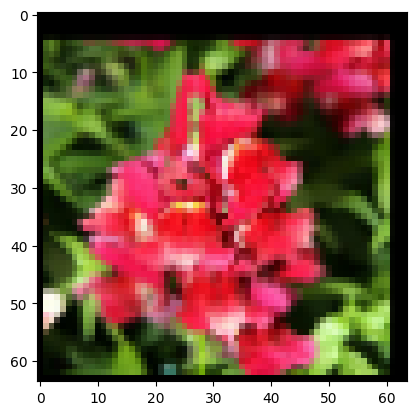

In [66]:
for img, caption in dataset.take(1):
    print(img.shape)
    new_img = image_aug(img)
    print(new_img.shape)
    plt.imshow(img[0].numpy())
    plt.show()
    plt.imshow(new_img[0].numpy())
    plt.show()

In [20]:
@tf.function
def train_step(real_image, caption, hidden):
    # random noise for generator
    noise = tf.random.normal(shape=[hparas['BATCH_SIZE'], hparas['Z_DIM']], mean=0.0, stddev=1.0)
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        text_embed, hidden = text_encoder(caption, hidden)
        _, fake_image = generator(text_embed, noise)

        # Do augmentation for both real and fake images
        real_image = image_aug(real_image)
        fake_image = image_aug(fake_image)

        real_logits, real_output = discriminator(real_image, text_embed)
        fake_logits, fake_output = discriminator(fake_image, text_embed)

        g_loss = generator_loss(fake_logits)
        d_loss = discriminator_loss(real_logits, fake_logits)

    grad_g = gen_tape.gradient(g_loss, generator.trainable_variables)
    grad_d = disc_tape.gradient(d_loss, discriminator.trainable_variables)
    # grad_text = gen_tape.gradient(g_loss, text_encoder.trainable_variables)

    generator_optimizer.apply_gradients(zip(grad_g, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(grad_d, discriminator.trainable_variables))
    # text_encoder_optimizer.apply_gradients(zip(grad_text, text_encoder.trainable_variables))
    
    return g_loss, d_loss

In [21]:
@tf.function
def test_step(caption, noise, hidden):
    text_embed, hidden = text_encoder(caption, hidden)
    _, fake_image = generator(text_embed, noise)
    return fake_image

## Visualization

In [22]:
def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((h * size[0], w * size[1], 3))
    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx // size[1]
        img[j*h:j*h+h, i*w:i*w+w, :] = image
    return img

def imsave(images, size, path):
    # getting the pixel values between [0, 1] to save it
    return plt.imsave(path, merge(images, size)*0.5 + 0.5)

def save_images(images, size, image_path):
    return imsave(images, size, image_path)

In [23]:
def sample_generator(caption, batch_size):
    caption = np.asarray(caption)
    caption = caption.astype(np.int)
    dataset = tf.data.Dataset.from_tensor_slices(caption)
    dataset = dataset.batch(batch_size)
    return dataset

In [24]:
# ni is just calulating grid layout
ni = int(np.ceil(np.sqrt(hparas['BATCH_SIZE'])))
sample_size = hparas['BATCH_SIZE']
sample_seed = np.random.normal(loc=0.0, scale=1.0, size=(sample_size, hparas['Z_DIM'])).astype(np.float32)
sample_sentence = ["the flower shown has yellow anther red pistil and bright red petals."] * int(sample_size/ni) + \
                  ["this flower has petals that are yellow, white and purple and has dark lines"] * int(sample_size/ni) + \
                  ["the petals on this flower are white with a yellow center"] * int(sample_size/ni) + \
                  ["this flower has a lot of small round pink petals."] * int(sample_size/ni) + \
                  ["this flower is orange in color, and has petals that are ruffled and rounded."] * int(sample_size/ni) + \
                  ["the flower has yellow petals and the center of it is brown."] * int(sample_size/ni) + \
                  ["this flower has petals that are blue and white."] * int(sample_size/ni) +\
                  ["these white flowers have petals that start off white in color and end in a white towards the tips."] * int(sample_size/ni)

for i, sent in enumerate(sample_sentence):
    sample_sentence[i] = sent2IdList(sent)
sample_sentence = sample_generator(sample_sentence, hparas['BATCH_SIZE'])

<ipython-input-23-fc27cc894c46>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  caption = caption.astype(np.int)


## Training

In [25]:
if not os.path.exists('samples/demo'):
    os.makedirs('samples/demo')

In [26]:
def train(dataset, epochs):
    # hidden state of RNN
    hidden = text_encoder.initialize_hidden_state()
    steps_per_epoch = int(hparas['N_SAMPLE']/hparas['BATCH_SIZE'])
    
    for epoch in range(hparas['N_EPOCH']):
        g_total_loss = 0
        d_total_loss = 0
        start = time.time()
        
        for image, caption in dataset:
            g_loss, d_loss = train_step(image, caption, hidden)
            g_total_loss += g_loss
            d_total_loss += d_loss
            
        time_tuple = time.localtime()
        time_string = time.strftime("%m/%d/%Y, %H:%M:%S", time_tuple)
            
        print("Epoch {}, gen_loss: {:.4f}, disc_loss: {:.4f}".format(epoch+1,
                                                                     g_total_loss/steps_per_epoch,
                                                                     d_total_loss/steps_per_epoch))
        print('Time for epoch {} is {:.4f} sec'.format(epoch+1, time.time()-start))
        
        # save the model
        if (epoch + 1) % 50 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        
        # visualization
        if (epoch + 1) % hparas['PRINT_FREQ'] == 0:
            for caption in sample_sentence:
                fake_image = test_step(caption, sample_seed, hidden)
            save_images(fake_image, [ni, ni], 'samples/demo/train_{:02d}.jpg'.format(epoch))

In [27]:
train(dataset, hparas['N_EPOCH'])

(64, 64, 64, 3) (64, 64, 64, 3)
(64, 64, 64, 3) (64, 64, 64, 3)
Epoch 1, gen_loss: 0.4477, disc_loss: 1.1363
Time for epoch 1 is 11.7314 sec


KeyboardInterrupt: 

## Evaluation
If you change anything during preprocessing of training dataset, you must make sure same operations have be done in testing dataset.

In [ ]:
def testing_data_generator(caption, index):
    caption = tf.cast(caption, tf.float32)
    return caption, index

def testing_dataset_generator(batch_size, data_generator):
    data = pd.read_pickle('./dataset/testData.pkl')
    captions = data['Captions'].values
    caption = []
    for i in range(len(captions)):
        caption.append(captions[i])
    caption = np.asarray(caption)
    caption = caption.astype(np.int)
    index = data['ID'].values
    index = np.asarray(index)
    
    dataset = tf.data.Dataset.from_tensor_slices((caption, index))
    dataset = dataset.map(data_generator, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.repeat().batch(batch_size)
    
    return dataset

In [ ]:
testing_dataset = testing_dataset_generator(hparas['BATCH_SIZE'], testing_data_generator)

<ipython-input-51-af1cd83bac2f>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  caption = caption.astype(np.int)


In [ ]:
data = pd.read_pickle('./dataset/testData.pkl')
captions = data['Captions'].values

NUM_TEST = len(captions)
EPOCH_TEST = int(NUM_TEST / hparas['BATCH_SIZE'])

## Inference

In [ ]:
if not os.path.exists('./inference/demo'):
    os.makedirs('./inference/demo')

In [ ]:
def inference(dataset):
    hidden = text_encoder.initialize_hidden_state()
    sample_size = hparas['BATCH_SIZE']
    sample_seed = np.random.normal(loc=0.0, scale=1.0, size=(sample_size, hparas['Z_DIM'])).astype(np.float32)
    
    step = 0
    start = time.time()
    for captions, idx in dataset:
        if step > EPOCH_TEST:
            break
        
        fake_image = test_step(captions, sample_seed, hidden)
        step += 1
        for i in range(hparas['BATCH_SIZE']):
            plt.imsave('./inference/demo/inference_{:04d}.jpg'.format(idx[i]), fake_image[i].numpy()*0.5 + 0.5)
            
    print('Time for inference is {:.4f} sec'.format(time.time()-start))

In [ ]:
checkpoint.restore(checkpoint_dir + '/ckpt-1')

NotFoundError: Error when restoring from checkpoint or SavedModel at ./checkpoints/demo/ckpt-1: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ./checkpoints/demo/ckpt-1
Please double-check that the path is correct. You may be missing the checkpoint suffix (e.g. the '-1' in 'path/to/ckpt-1').

In [ ]:
inference(testing_dataset)

Time for inference is 1.4534 sec


## Inception Score & Cosine Similarity
- Similarity of images and the given contents. How similar are the generated images and the given texts?
- KL divergence of generated images. Are the generated images very diverse?

### Run evaluation script

1. Open terminal and move to the folder containing inception_score.py. Otherwise you have to modify the path used in the file.
2. Run python ./inception_score.py [argv1] [argv2] [argv3]
    - argv1: directory of generated image (inference).
    - argv2: directory of output file and its name.
    - argv3: batch size. Please set batch size to 1, 2, 3, 7, 9, 21, 39 to avoid remainder.

For exmaple, run following comment 
`python inception_score.py ../inference/demo ../score_demo.csv 39`

It is better for you to know that evaluation needs to run on GPUs, please make sure the GPU resource is available.